# Deliverable 2
## Scrape and Analyze Mars Weather Data

In [1]:
# Import Dependencies 
from splinter import Browser
from bs4 import BeautifulSoup as soup
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Setup executable path and browser for automation
executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)

In [3]:
# load the mars weather table site in the browser
url = 'https://data-class-mars-challenge.s3.amazonaws.com/Mars/index.html'
browser.visit(url)

# delay loading the page before automation
browser.is_element_present_by_css("main table.table  tr.data-row", wait_time=1)
html = browser.html

## Requirement 1

In [4]:
# Either Pandas or Splinter and Beautiful Soup were used to scrape the data.
table_soup = soup(html,'html.parser')
table_list = table_soup.select('main table.table tr.data-row')

table_rows = []
for x in table_list:
    col = x.findAll("td")
    table_rows.append({
        "id": col[0].get_text(),
        "terrestrial_date": col[1].get_text(),
        "sol": col[2].get_text(),
        "ls": col[3].get_text(),
        "month": col[4].get_text(),
        "min_temp": col[5].get_text(),
        "pressure": col[6].get_text()
    })

In [5]:
# The HTML table was extracted into a Pandas DataFrame.
df = pd.DataFrame(table_rows, columns=['id', 'terrestrial_date', 'sol', 'ls', 'month', 'min_temp', 'pressure'])
df.set_index('id', inplace=True)

In [6]:
# The columns have the correct headings and data types.
df['terrestrial_date'] = pd.to_datetime(df['terrestrial_date'])
df['sol'] = df['sol'].astype('int')
df['ls'] = df['ls'].astype('int')
df['month'] = df['month'].astype('int')
df['min_temp'] = df['min_temp'].astype('float')
df['pressure'] = df['pressure'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1867 entries, 2 to 1895
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   terrestrial_date  1867 non-null   datetime64[ns]
 1   sol               1867 non-null   int32         
 2   ls                1867 non-null   int32         
 3   month             1867 non-null   int32         
 4   min_temp          1867 non-null   float64       
 5   pressure          1867 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int32(3)
memory usage: 80.2+ KB


In [7]:
df

,terrestrial_date,sol,ls,month,min_temp,pressure
id,,,,,,
2,2012-08-16,10,155,6,-75.0,739.0
13,2012-08-17,11,156,6,-76.0,740.0
24,2012-08-18,12,156,6,-76.0,741.0
35,2012-08-19,13,157,6,-74.0,732.0
46,2012-08-20,14,157,6,-74.0,740.0
...,...,...,...,...,...,...
1889,2018-02-23,1973,133,5,-78.0,730.0
1892,2018-02-24,1974,134,5,-77.0,729.0
1894,2018-02-25,1975,134,5,-76.0,729.0


## Requirement 2

The data was analyzed to answer the following questions, and a data visualization was created to support each answer.

In [8]:
# How many months exist on Mars?
df['month'].max()

12

In [9]:
# How many Martian (and not Earth) days worth of data exist in the scraped dataset?
df['sol'].nunique()

1867

The coldest was month number 3 , with an average of -83 celsius. 
The warmest was month number 8 , with an average of -68 celsius.


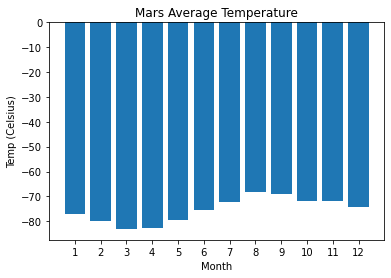

In [10]:
# What are the coldest and the warmest months on Mars?

# Get the answer by averaging the minimum daily temperature of all the months.
monthly_mean = df.groupby('month').mean().reset_index()
month_min_temp = monthly_mean.loc[monthly_mean['min_temp'] == monthly_mean['min_temp'].min(),['month','min_temp']]
month_max_temp = monthly_mean.loc[monthly_mean['min_temp'] == monthly_mean['min_temp'].max(),['month','min_temp']]

print(
    'The coldest was month number', int(month_min_temp.to_numpy()[0][0]),
    ', with an average of', int(month_min_temp.to_numpy()[0][1]), 'celsius.',
    '\nThe warmest was month number', int(month_max_temp.to_numpy()[0][0]),
    ', with an average of', int(month_max_temp.to_numpy()[0][1]), 'celsius.',
)

# Plot the results as a bar chart.
plt.bar(monthly_mean['month'],monthly_mean['min_temp'])
plt.xlabel('Month')
plt.ylabel('Temp (Celsius)')
plt.title("Mars Average Temperature")
tick_locations = [value for value in monthly_mean['month']]
plt.xticks(tick_locations)
plt.show()

The lowest atmospheric pressure was in month number 6 , with an average of 745 . 
The highest atmospheric pressure was in month number 9 , with an average of 913 .


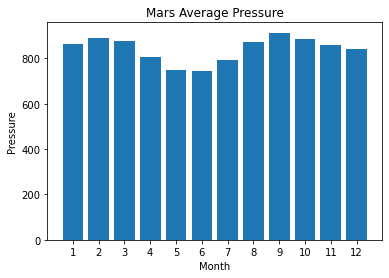

In [11]:
# Which months have the lowest and the highest atmospheric pressure on Mars?

# Get the answer by averaging the daily atmospheric pressure of all the months.
month_min_pressure = monthly_mean.loc[monthly_mean['pressure'] == monthly_mean['pressure'].min(),['month','pressure']]
month_max_pressure = monthly_mean.loc[monthly_mean['pressure'] == monthly_mean['pressure'].max(),['month','pressure']]

print(
    'The lowest atmospheric pressure was in month number', int(month_min_pressure.to_numpy()[0][0]),
    ', with an average of', int(month_min_pressure.to_numpy()[0][1]), '.',
    '\nThe highest atmospheric pressure was in month number', int(month_max_pressure.to_numpy()[0][0]),
    ', with an average of', int(month_max_pressure.to_numpy()[0][1]), '.'
)

# Plot the results as a bar chart.
plt.bar(monthly_mean['month'],monthly_mean['pressure'])
plt.xlabel('Month')
plt.ylabel('Pressure')
plt.title("Mars Average Pressure")
tick_locations = [value for value in monthly_mean['month']]
plt.xticks(tick_locations)
plt.show()

One year on mars is approximately 685 days 00:00:00 days on earth.


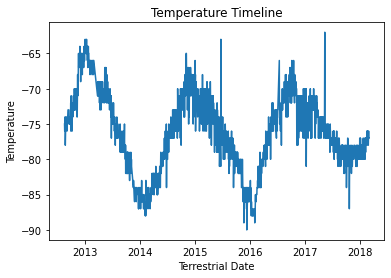

In [12]:
# About how many terrestrial (Earth) days exist in a Martian year?

# That is, in the time that Mars circles the Sun once, how many days elapse on Earth?
start_date_df = df.loc[df['ls'] == df['ls'].min()]
start_date_df = start_date_df.iloc[0]['terrestrial_date']
end_date_df = df.loc[df['ls'] == df['ls'].max()]
end_date_df = end_date_df.loc[end_date_df['terrestrial_date'] > start_date_df]
end_date_df = end_date_df.iloc[0]['terrestrial_date']

print('One year on mars is approximately', end_date_df - start_date_df, 'days on earth.')

# Visually estimate the result by plotting the daily minimum temperature.
plt.plot(df['terrestrial_date'], df['min_temp'])
plt.xlabel('Terrestrial Date')
plt.ylabel('Temperature')
plt.title('Temperature Timeline')
plt.show()

## Requirement 3

In [13]:
# Export the DataFrame to a CSV file.
output_data_file = 'mars_html_dataframe.csv'
df.to_csv(output_data_file, encoding = 'utf8', index = False)

In [14]:
browser.quit()